In [ ]:
# Data processing
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# local python scripts package
from utils import cleanup
from utils import plots
from utils.plots import PlotType

# Logging
import logging
# setup logging level
logging.getLogger().setLevel(logging.DEBUG)





In [31]:
# import dataset
data = pd.read_csv("../dataset/king_country_houses_aa.csv")
df = data.copy()
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [32]:
# initiate a new instance of plots class 
# set color palette and theme for maximum of colors set to columns count
plots = plots.Gryffindor_plots(n_columns=df.shape[1], target_column='price')

## Feature engineering

- Target variable: price
- Numerical features: sqft_living, sqft_lot, bedrooms, bathrooms, floors, etc.
- Categorical features: zipcode (which needs encoding)
- Datetime feature: date (which is currently an object/string)

- log-transforming highly skewed numerical features

In [48]:
descrete_columns = []
descrete_columns.append('view')
descrete_columns.append('bedrooms')
descrete_columns.append('bathrooms')
descrete_columns.append('floors')
descrete_columns.append('zipcode')
descrete_columns.append('yr_built')
descrete_columns.append('yr_renovated')
print(descrete_columns)

['view', 'bedrooms', 'bathrooms', 'floors', 'zipcode', 'yr_built', 'yr_renovated']


In [50]:
categorical_columns = []
categorical_columns.append('date') # questionable
categorical_columns.append('id')
categorical_columns.append('waterfront')
categorical_columns.append('grade')
categorical_columns.append('condition')
print(categorical_columns)

['date', 'id', 'waterfront', 'grade', 'condition']


In [83]:
# do not include target column 'price' to continuous column names list
continuous_columns = []
continuous_columns.append('sqft_lot')
continuous_columns.append('sqft_lot15')
continuous_columns.append('sqft_above')
continuous_columns.append('sqft_basement')
continuous_columns.append('sqft_living')
continuous_columns.append('lat')
continuous_columns.append('long')

# Random Forest

In [100]:
df = data.copy()

# Define price categories
df['price_category'] = pd.qcut(df['price'], q=3, labels=['Low', 'Medium', 'High'])

# Drop unnecessary columns
df = df.drop(columns=['id', 'date', 'price'])

# Encode categorical variables if necessary
if df['zipcode'].dtype == 'int64':
    df['zipcode'] = df['zipcode'].astype(str)  # Convert to string to treat as categorical

# Convert categorical column to numerical representation
label_enc = LabelEncoder()
df['zipcode'] = label_enc.fit_transform(df['zipcode'])

# Define features and target
X = df.drop(columns=['price_category'])
y = df['price_category']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)



In [101]:
accuracy

0.8359935230164238

In [104]:
print(class_report)

              precision    recall  f1-score   support

        High       0.87      0.84      0.86      1433
         Low       0.89      0.88      0.88      1445
      Medium       0.75      0.79      0.77      1445

    accuracy                           0.84      4323
   macro avg       0.84      0.84      0.84      4323
weighted avg       0.84      0.84      0.84      4323



In [103]:
conf_matrix

array([[1208,   10,  215],
       [   9, 1265,  171],
       [ 164,  140, 1141]])

<Figure size 800x600 with 0 Axes>

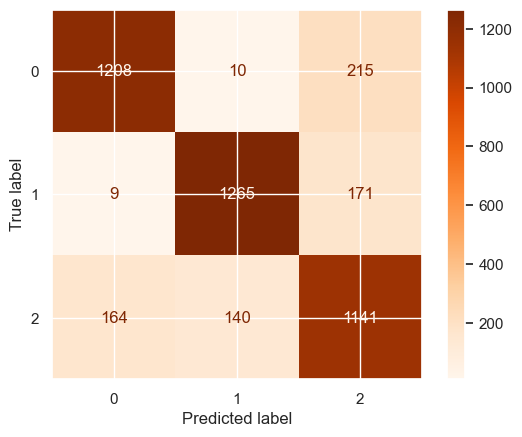

In [98]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

### Hyperparameter tuning

- max_depth (Maximum Depth of the Tree)
  - Controls how deep each decision tree in the Random Forest can grow.
  - If too low, the model underfits (does not capture enough complexity).
  - If too high, the model overfits (memorizes training data but performs poorly on new data).
- min_samples_split (Minimum Samples Required to Split a Node)
  - Defines the minimum number of samples needed to split an internal node.
  - If too low, the model may overfit (splits too much).
  - If too high, the model may underfit (does not split enough).

In [ ]:
# Copy the dataset
df = df.copy()

# Define price categories
df['price_category'] = pd.qcut(df['price'], q=3, labels=['Low', 'Medium', 'High'])

# Drop unnecessary columns
df = df.drop(columns=['id', 'date', 'price'])

# Convert categorical column to numerical representation
label_enc = LabelEncoder()
df['zipcode'] = label_enc.fit_transform(df['zipcode'].astype(str))

# Define features and target
X = df.drop(columns=['price_category'])
y = df['price_category']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # None allows trees to grow fully
    'min_samples_split': [2, 5, 10, 20]  # Default is 2, higher values reduce overfitting
}

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
grid_search.best_params_, grid_search.best_score_

NameError: name 'df' is not defined